Analüüsi eesmärk on:
    * pideva muutuja averageGrade ennustamine.
    * andmestiku struktuuri kirjeldamine (dimensionaalsuse vähendamine, klasterdamine).

Algandmed on hoiustatud json failis, mille loen mällu ja kirjutan kolme erinevasse .csv faili, kus igaühes neist on esitatud kõik andmestiku omadused aga veidi erineval kujul, et seda hiljem lihtsam kasutada oleks.

In [988]:
import json
import csv


def convert_dict_to_csv(dict):
    csv_file = "students"

    csv_columns = ['id', 'uniid', 'lastTested', 'totalCommits', 'totalTestsRan', 'totalTestsPassed',
                   'totalDiagnosticErrors', 'differentSlugs', 'differentCourses', 'commitsStyleOK', 'averageGrade',
                   'medianGrade']  # Last one is the one being predicted

    csv_columns_percent = ['totalDiagnosticErrors_per_totalCommits', 'totalTestsPassed_per_totalTestsRan',
                           'commitsStyleOK_per_totalCommits', ]

    to_drop = ['id', 'uniid', 'lastTested', 'medianGrade']
    to_drop_extra_only = ['totalCommits', 'totalTestsRan', 'differentCourses', 'totalTestsPassed',
                          'totalDiagnosticErrors', 'commitsStyleOK']

    try:

        for i in range(3):
            with open(csv_file + ("_extra.csv" if i == 1 else ".csv" if not i else "_extra_only.csv"), 'w') as csvfile:
                if i == 1:
                    csv_columns = csv_columns_percent + csv_columns

                if i == 2:
                    csv_columns = [x for x in csv_columns if x not in to_drop_extra_only]

                csv_columns = [x for x in csv_columns if x not in to_drop]

                writer = csv.DictWriter(csvfile, delimiter=',', lineterminator='\n', fieldnames=csv_columns)

                csvfile.write(
                    f"{len(dict)},{len(csv_columns) - 1}\n")  # -1 because the last field is the one being predicted
                writer.writeheader()

                for data in reversed(dict):
                    if not i:
                        for drop in to_drop:
                            del data[drop]

                    if i:
                        for extra in csv_columns_percent:
                            left, right = extra.split("_per_")

                            if not data[right]:
                                data[extra] = 0
                            else:
                                data[extra] = data[left] / data[right]

                        if i == 2:
                            for drop in to_drop_extra_only:
                                del data[drop]

                    writer.writerow(data)
    except IOError:
        print("I/O error")



with open('example.json') as f:
    dict_data = json.load(f)
convert_dict_to_csv(dict_data)


student.csv description:

Author: Enrico Vompa
Date: 2020.03.20

Data is collected from Arete. (TalTech's automated testing service)

Dataset contains no NULL fields.

Nr of lines: 138
Nr of attributes: 8

Headers:
 - totalCommits (integer) - Total number of commits from the student
 - totalTestsRan (integer) - Total number of tests ran for the student
 - totalTestsPassed (integer) - Total number of tests passed from the tests ran
 - totalDiagnosticErrors (integer) - Total number of diagnostic errors. Diagnostic error = style error in code. Eslint for example.
 - differentSlugs (integer) - Number of different exercises the given student has attempted
 - differentCourses (integer) - Number of different courses the given student has attempted
 - commitsStyleOK (integer) - Number of test jobs ran with no diagnostic errors
 - averageGrade (float) - students' average score

students_extra.csv description:

Author: Enrico Vompa
Date: 2020.04.11

Data is collected from Arete. (TalTech's automated testing service)

Dataset contains no NULL fields.

Nr of lines: 138
Nr of attributes: 11

Headers:
 - totalDiagnosticErrors_per_totalCommits (float) - totalDiagnosticErrors divided by totalCommits
 - totalTestsPassed_per_totalTestsRan (float) - totalTestsPassed divided by totalTestsRan
 - commitsStyleOK_per_totalCommits (float) - commitsStyleOK divided by totalCommits
 - totalCommits (integer) - Total number of commits from the student
 - totalTestsRan (integer) - Total number of tests ran for the student
 - totalTestsPassed (integer) - Total number of tests passed from the tests ran
 - totalDiagnosticErrors (integer) - Total number of diagnostic errors. Diagnostic error = style error in code. Eslint for example.
 - differentSlugs (integer) - Number of different exercises the given student has attempted
 - differentCourses (integer) - Number of different courses the given student has attempted
 - commitsStyleOK (integer) - Number of test jobs ran with no diagnostic errors
 - averageGrade (float) - students' average score

students_extra_only.csv description:

Author: Enrico Vompa
Date: 2020.04.11

Data is collected from Arete. (TalTech's automated testing service)

Dataset contains no NULL fields.

Nr of lines: 138
Nr of attributes: 5

Headers:
 - totalDiagnosticErrors_per_totalCommits (float) - totalDiagnosticErrors divided by totalCommits
 - totalTestsPassed_per_totalTestsRan (float) - totalTestsPassed divided by totalTestsRan
 - commitsStyleOK_per_totalCommits (float) - commitsStyleOK divided by totalCommits
 - differentSlugs (integer) - Number of different exercises the given student has attempted
 - averageGrade (float) - students' average score

In [989]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.cluster import KMeans

def load_dataset(filename):
    with open(filename) as csv_file:
        data_file = csv.reader(csv_file)
        temp = next(data_file)
        n_samples = int(temp[0])
        n_features = int(temp[1])
        temp = next(data_file)
        columns2= [x.strip() for x in temp]
        data = np.empty((n_samples, n_features), dtype=np.int64)
        target = np.empty((n_samples,), dtype=np.int64)

        for i, sample in enumerate(data_file):
            data[i] = np.asarray([int(round(float(x))) for x in sample[:-1]], dtype=np.int64)
            target[i] = np.asarray(int(round(float(sample[-1]) / 10)) * 10, dtype=np.int64)

    return Bunch(data=data, target=target),columns2

def getColumns(filename):
    with open(filename) as f:
        f.readline() # holder for dimensions
        columns = [x.strip() for x in f.readline().split(",")]
        return columns

Alustab andmete lugemisega

In [990]:
used_columns = getColumns("students.csv")
    
student_df = pd.read_csv("students.csv", 
                      header=2, 
                      names=used_columns)
student_df

,totalCommits,totalTestsRan,totalTestsPassed,totalDiagnosticErrors,differentSlugs,differentCourses,commitsStyleOK,averageGrade
0,110,3071,2377,684,15,1,23,100.000000
1,45,1167,999,532,12,1,9,89.644167
2,165,5050,4445,1486,19,1,59,88.670000
3,393,9636,6812,3615,18,1,90,86.526667
4,29,324,142,288,4,1,3,84.167500
...,...,...,...,...,...,...,...,...
132,6,306,273,64,2,1,2,100.000000
133,10,186,150,109,10,1,5,82.000000
134,3,3,0,2,1,1,1,0.000000
135,10,41,33,1438,2,1,0,40.245000


In [991]:
print("Mean of __")
_ = [print(f"        {x} is: {student_df[x].mean()}") for x in used_columns]
print()

print("Median of __")
_ = [print(f"          {x} is: {student_df[x].median()}") for x in used_columns]
print()

print("Standard deviation of __")
_ = [print(f"                      {x} is: {student_df[x].std()}") for x in used_columns]

Mean of __
        totalCommits is: 128.007299270073
        totalTestsRan is: 3688.204379562044
        totalTestsPassed is: 2776.934306569343
        totalDiagnosticErrors is: 1538.6788321167883
        differentSlugs is: 12.912408759124087
        differentCourses is: 1.0364963503649636
        commitsStyleOK is: 30.021897810218977
        averageGrade is: 80.28005150497724

Median of __
          totalCommits is: 114.0
          totalTestsRan is: 3452.0
          totalTestsPassed is: 2574.0
          totalDiagnosticErrors is: 1173.0
          differentSlugs is: 16.0
          differentCourses is: 1.0
          commitsStyleOK is: 26.0
          averageGrade is: 88.67

Standard deviation of __
                      totalCommits is: 101.1357195547563
                      totalTestsRan is: 3015.727609839023
                      totalTestsPassed is: 2222.3034525821454
                      totalDiagnosticErrors is: 1398.3286606343904
                      differentSlugs is: 6.35178813

Eelnevatest Järeldab, et andmeid on vaja standartiseerida enne nende kasutust.

Histogrammid, et vaadata andmete jaotust

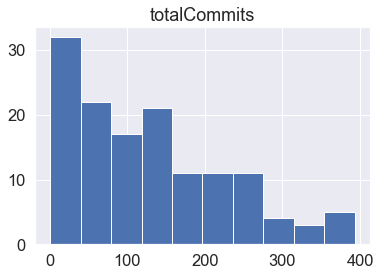

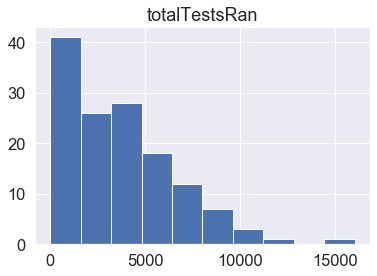

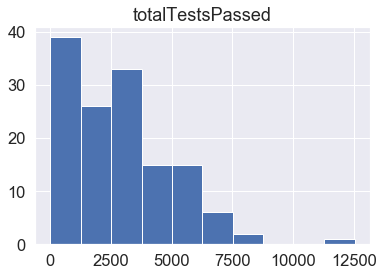

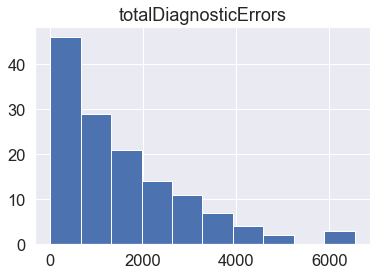

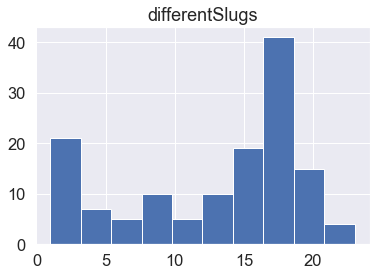

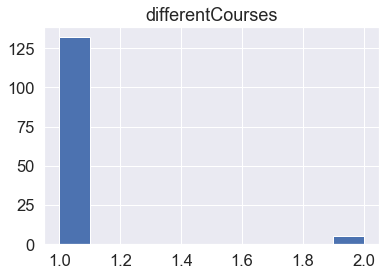

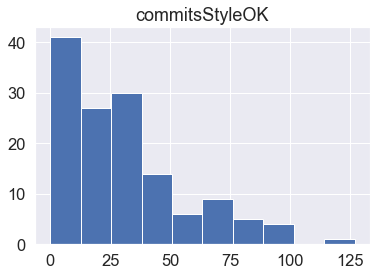

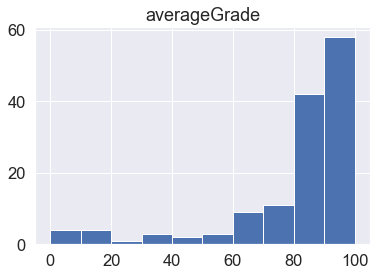

In [992]:
_ = [student_df.hist(column=x) for x in used_columns] ## Bigger pictures this way

Pairplots, et vaadata andmete jaotust ning uurida, millised kolumni väärtused on omavahel otseselt seotud graafiliselt

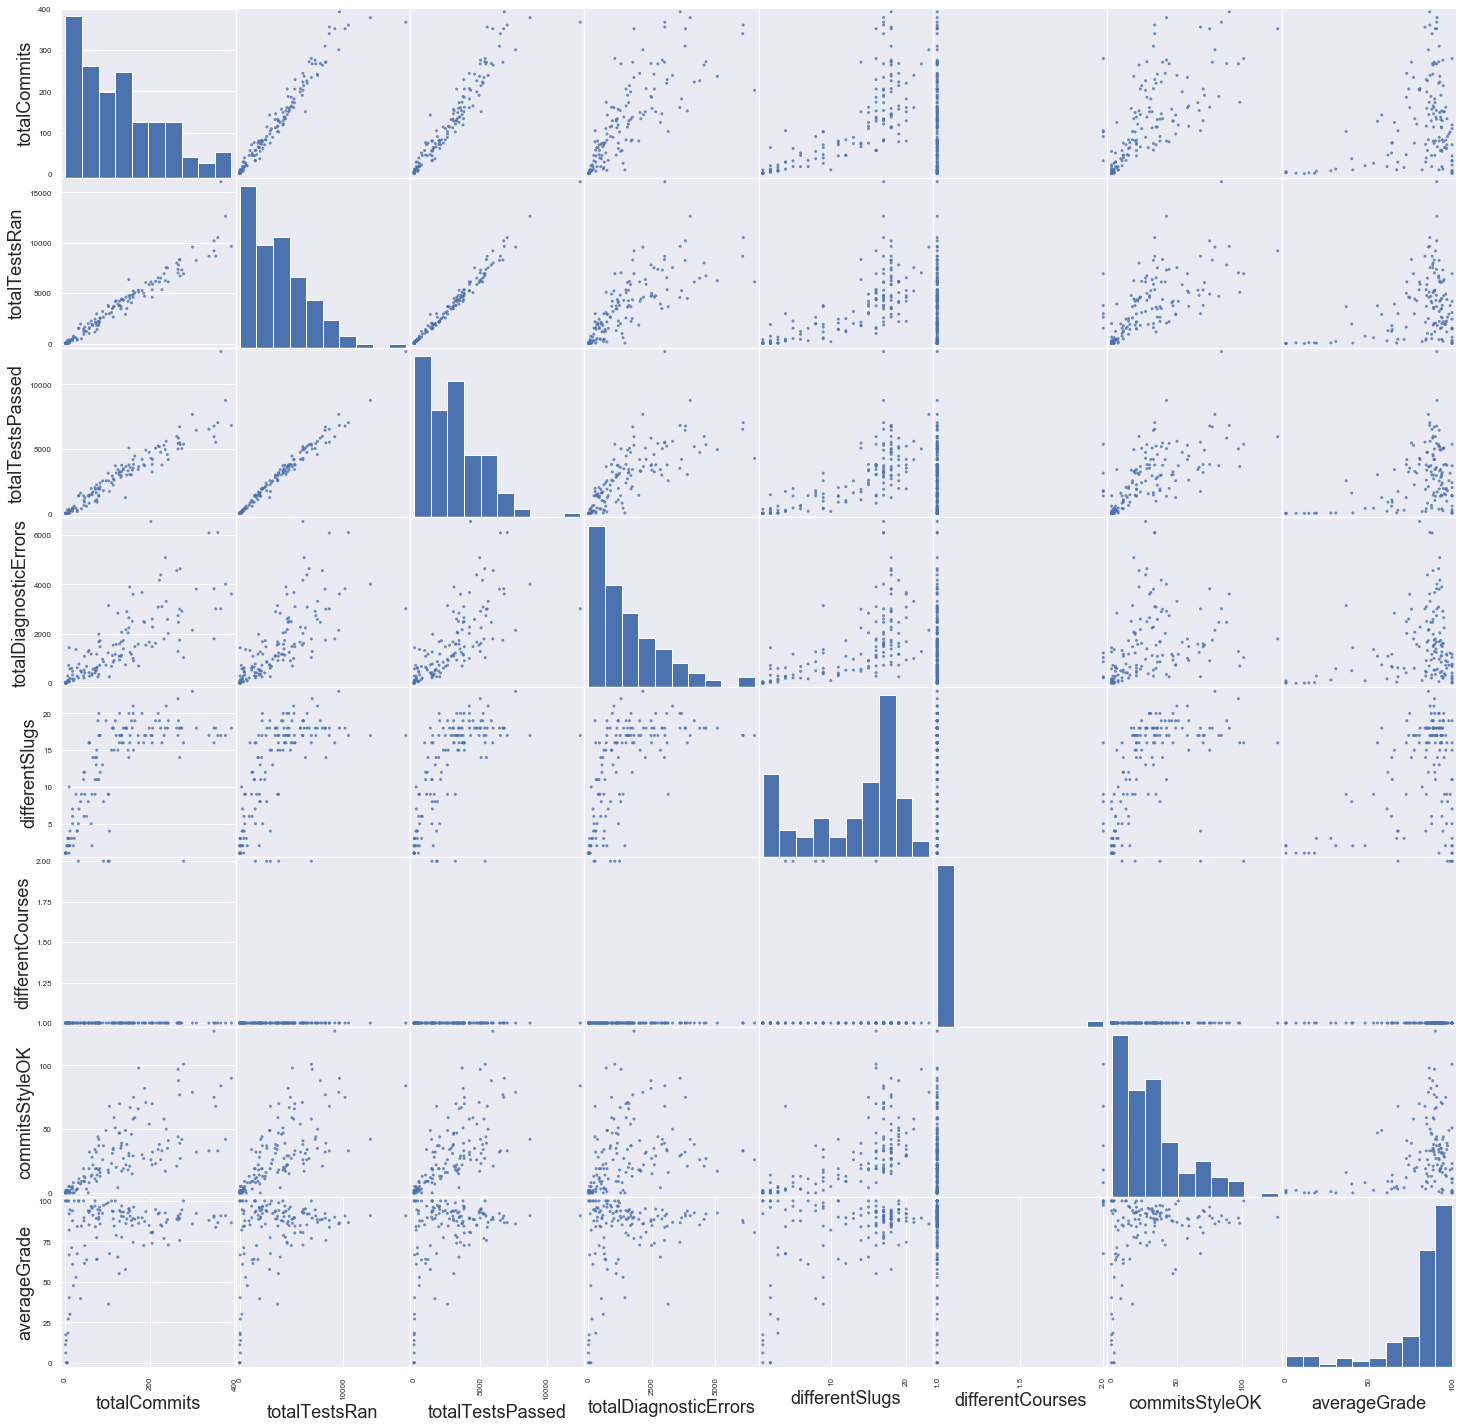

In [993]:
_ = scatter_matrix(student_df, figsize = (25, 25), alpha=0.8)

Sai joonistatud scatter_matix, et proovida leida seoseid testimiselt tulnud andmete ja keskmise hinde vahel. Aga suuri otseseid seoseid ei paista olevat. Selleks tuleks joonistada korrelatsioonimaatriks, et kindel olla.

Korrelatsioonimaatriks, et uurida millised kolumni väärtused on omavahel otseselt seotud

In [994]:
def histogram_intersection(a, b):
    v = np.minimum(a, b).sum().round(decimals=1)
    return v

student_df.corr(method=histogram_intersection)

,totalCommits,totalTestsRan,totalTestsPassed,totalDiagnosticErrors,differentSlugs,differentCourses,commitsStyleOK,averageGrade
totalCommits,1.0,17531.0,17524.0,17534.0,1769.0,142.0,4113.0,8923.1
totalTestsRan,17531.0,1.0,380440.0,205784.0,1767.0,141.0,4113.0,10818.6
totalTestsPassed,17524.0,380440.0,1.0,199979.0,1764.0,139.0,4110.0,10770.3
totalDiagnosticErrors,17534.0,205784.0,199979.0,1.0,1768.0,141.0,4111.0,10754.4
differentSlugs,1769.0,1767.0,1764.0,1768.0,1.0,142.0,1678.0,1764.0
differentCourses,142.0,141.0,139.0,141.0,142.0,1.0,132.0,139.0
commitsStyleOK,4113.0,4113.0,4110.0,4111.0,1678.0,132.0,1.0,4048.6
averageGrade,8923.1,10818.6,10770.3,10754.4,1764.0,139.0,4048.6,1.0


Siin tunduvad suvalised numbrid olevat, niiet ka see väga palju midagi ei ütle.

Paneb graafikud samasse teljestikku, et vaadata, millised andmed on umbkaudu samas suurusjärgus

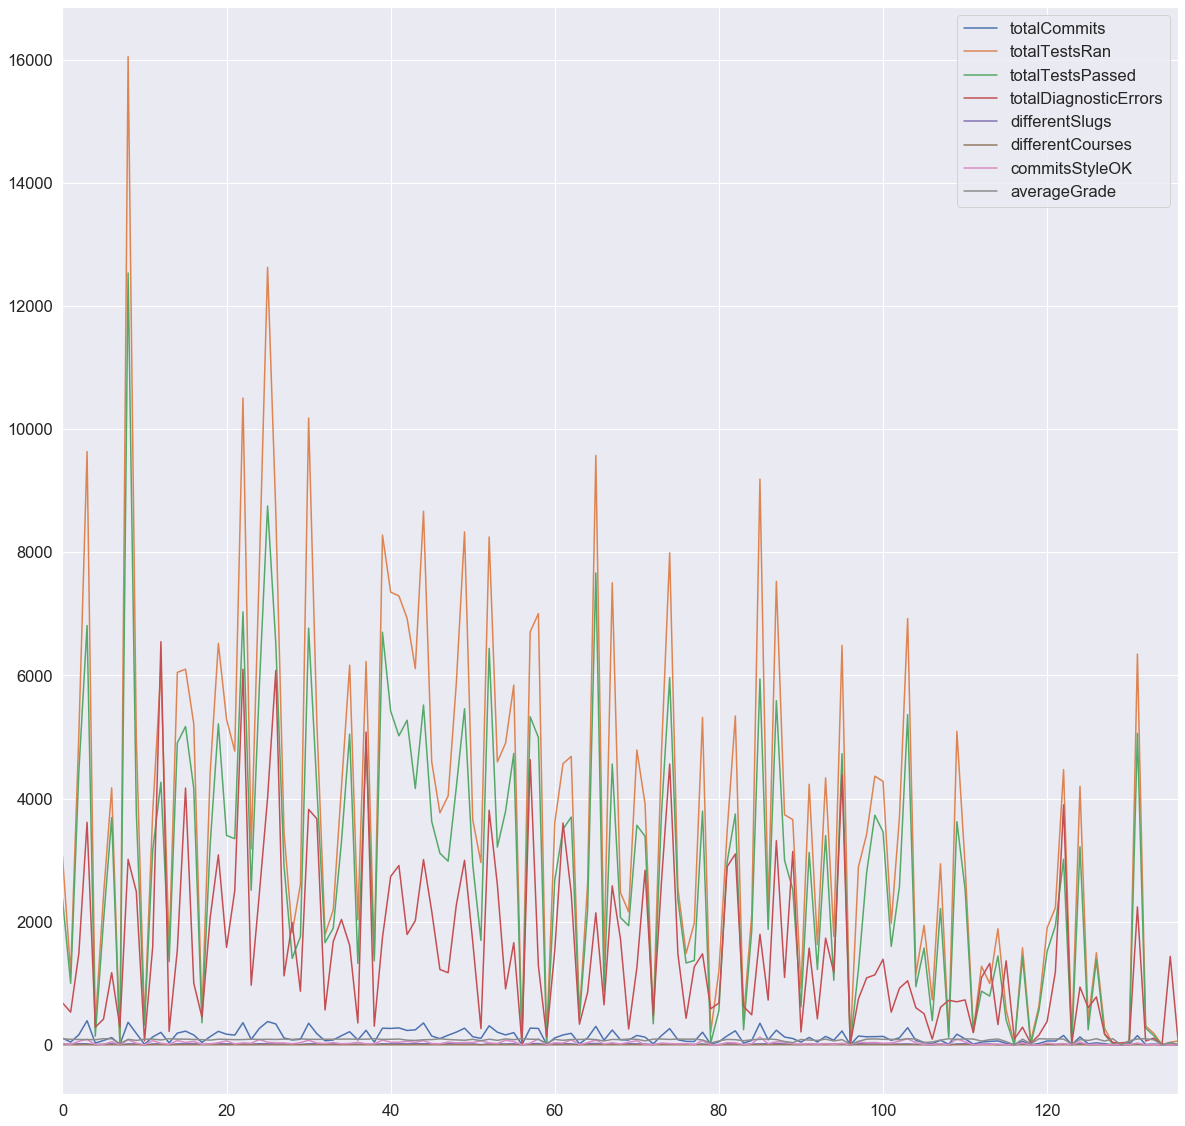

In [995]:
_ = student_df.plot(figsize=(20, 20))

Andmeid on igast suurusjärke, et tuleb standartiseerida kuidagi vastuseid

Joonistab korrelatsiooni koefitsendi maatriksi vahemikus -1 kuni 1, et oleks lihtsamini loetav ning visualiseerib need clustermap'ina ning heatmap'ina

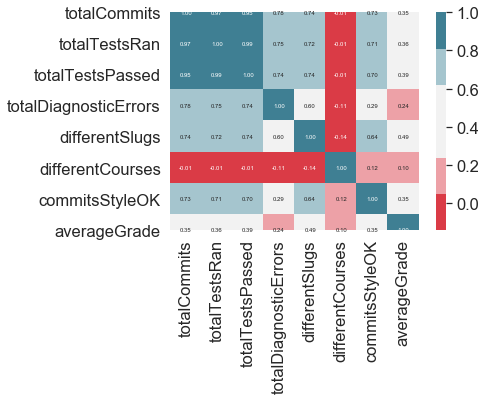

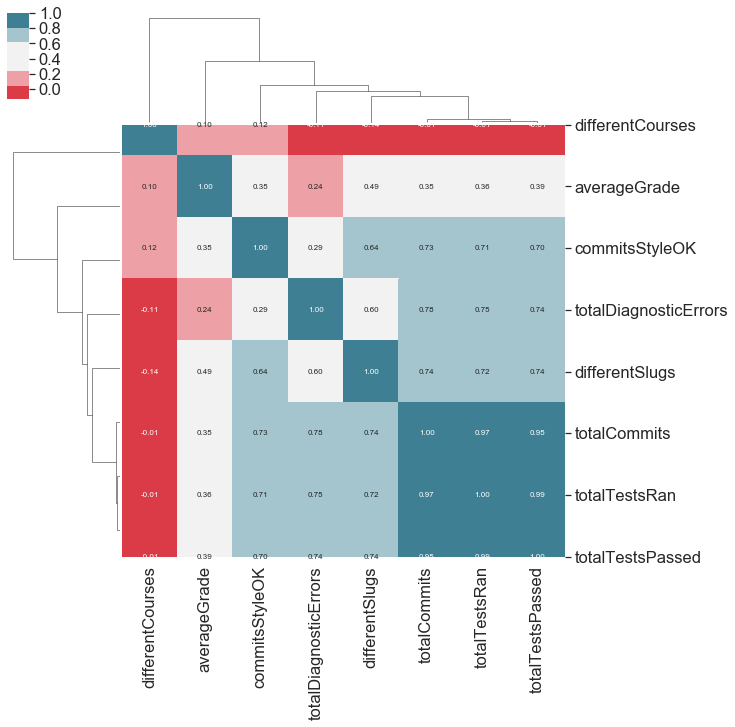

In [996]:
def draw_coefficient_matrix(student_df):
    X = student_df
    y = student_df.columns
    
    cm = np.corrcoef(X.T)
    sns.set(font_scale=1.5)
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f',
                     annot_kws={'size': 6}, yticklabels=X.columns,
                     xticklabels=X.columns, 
                     cmap=sns.diverging_palette(10, 220, sep=80))
    plt.show()

    km = sns.clustermap(cm, cbar=True, annot=True,fmt='.2f',
                        annot_kws={'size': 8}, yticklabels=X.columns,
                        xticklabels=X.columns, 
                        cmap=sns.diverging_palette(10, 220, sep=80))
    plt.show()

draw_coefficient_matrix(student_df)

Eelnevatest andmetest saab järeldata järgmist - Huvitaval kombel pole keskmise hinne otseselt seotud muude kolumni väärtustega. (Koefitsendi väärtused korrelatsioonimaatriksis real averageGrade on alla .4)

Erinevate kursuste arv on vastupidises suhtes erinevate ülesannete arvuga - Mille põhjendus on ilmselt see, et andmeid ei ole piisavalt pika aja peale. Peaks seda faili jooksutama uuesti kunagi tulevikus.

Ootuspäraselt on totalCommits, totalTestsRan ja totalTestsPassed omavahel samasuunalises suhtes.

Panen paar täiendavat fieldi sisse, millest saaks ehk midagi järeldada


In [997]:
student_df_extra = pd.read_csv("students_extra.csv", 
                      header=2, 
                      names=getColumns("students_extra.csv"))

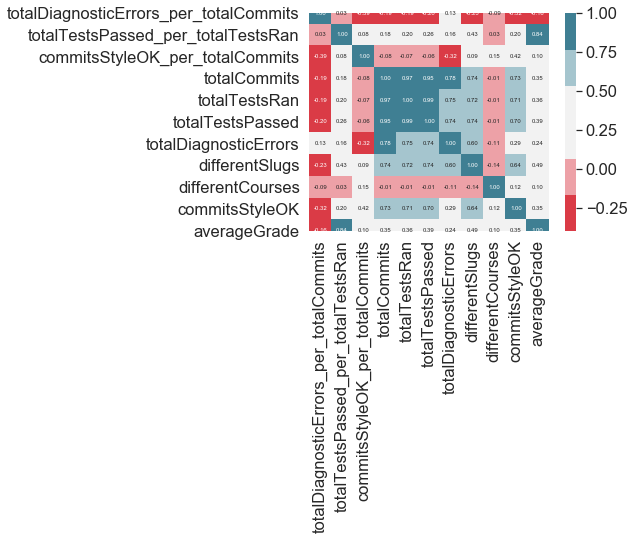

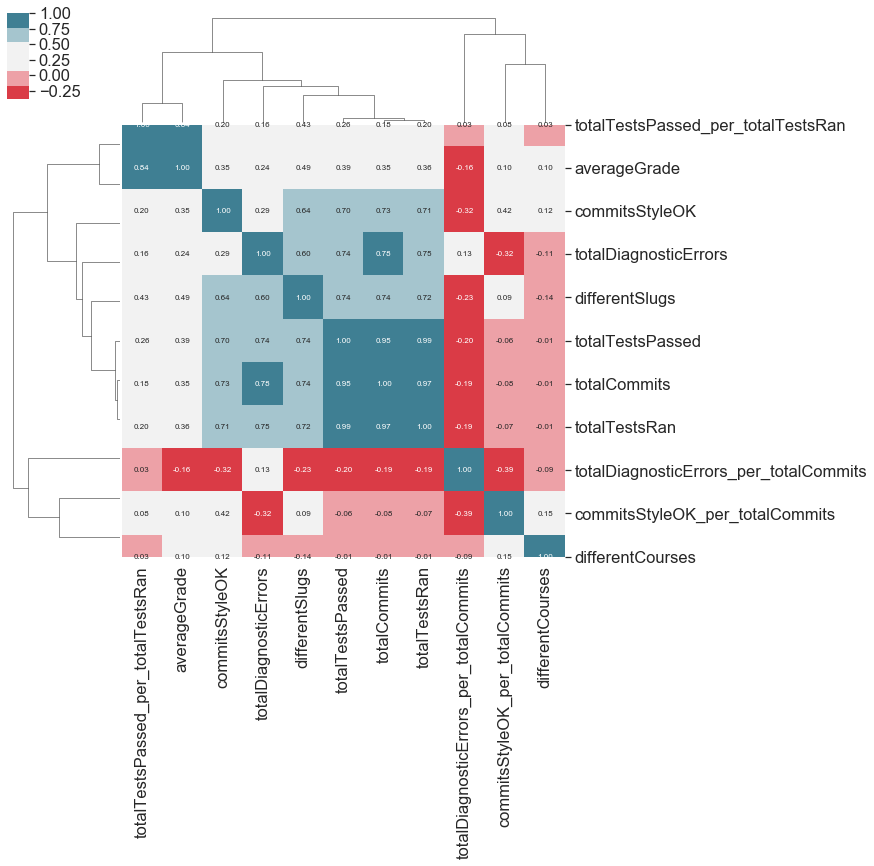

In [998]:
draw_coefficient_matrix(student_df_extra)

Ning ootuspäraselt tekkis seos keskmise hinde ning totalTestsPassed_per_totalTestsRan vahel

Aga huvitaval kombel ei ole commitsStyleOK_per_totalCommits ega totalDiagnosticErrors_per_totalCommits vead kuidagi seotud keskmise hindega

In [999]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

def draw_silhouette_plots(X, range_n_clusters = range(2, 10)):

# See kood on võetud suuresti 
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
    distortions = []
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        distortions.append(clusterer.inertia_)
        
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()
    
    plt.plot(range(2, 10), distortions)
    plt.xlabel("Clusters")
    plt.ylabel("Distortions")
    plt.show()

Järgmiseks proovin klasterdamist, et vaadata, kas on võimalik andmeid klastritesse jaotada. Isiklikult arvan, et ei. Aga et kindel olla, siis proovin küünarnukki meetodit siluetidiagrammidel.

For n_clusters = 2 The average silhouette_score is : 0.5468948830687307
For n_clusters = 3 The average silhouette_score is : 0.5228355601330393
For n_clusters = 4 The average silhouette_score is : 0.5256810377093334
For n_clusters = 5 The average silhouette_score is : 0.4825687499187385
For n_clusters = 6 The average silhouette_score is : 0.4658916269870316
For n_clusters = 7 The average silhouette_score is : 0.47190446022596666
For n_clusters = 8 The average silhouette_score is : 0.4585603084493756
For n_clusters = 9 The average silhouette_score is : 0.4505743148035646


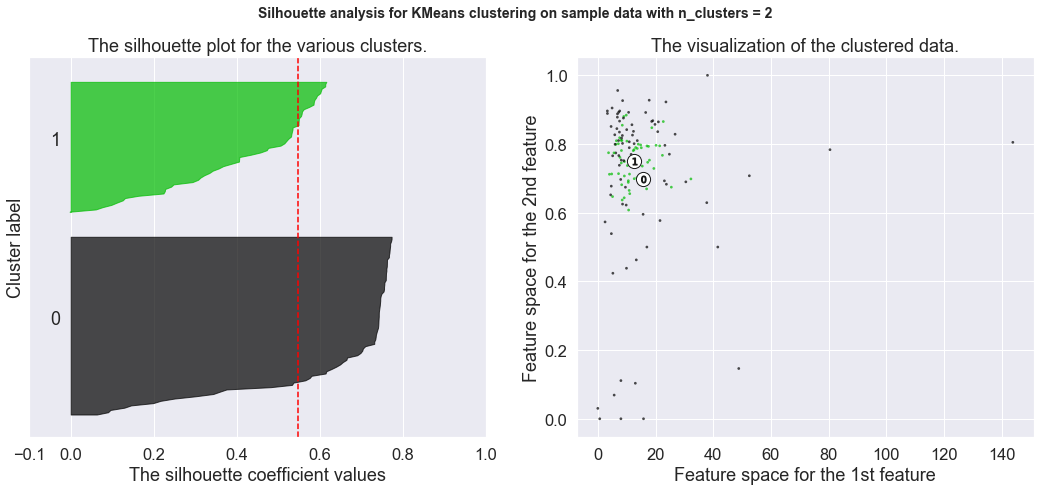

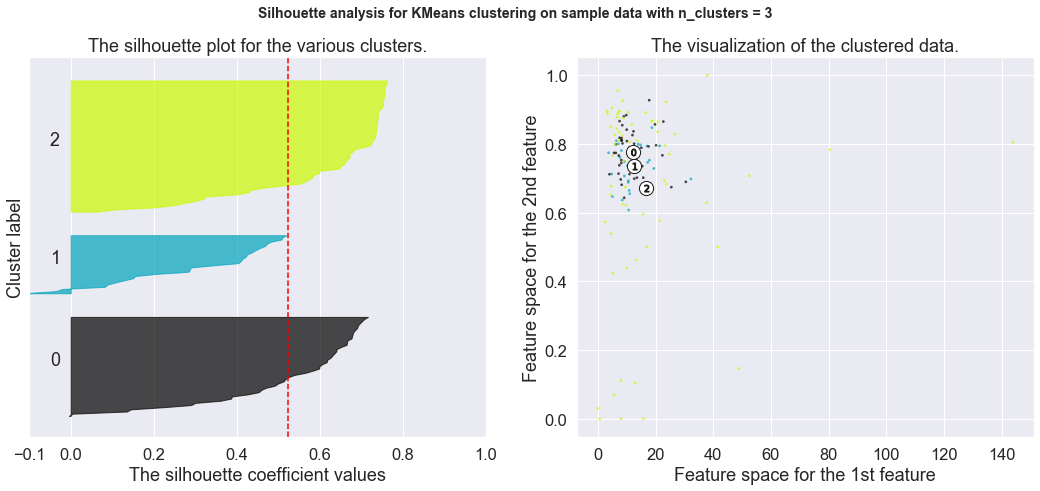

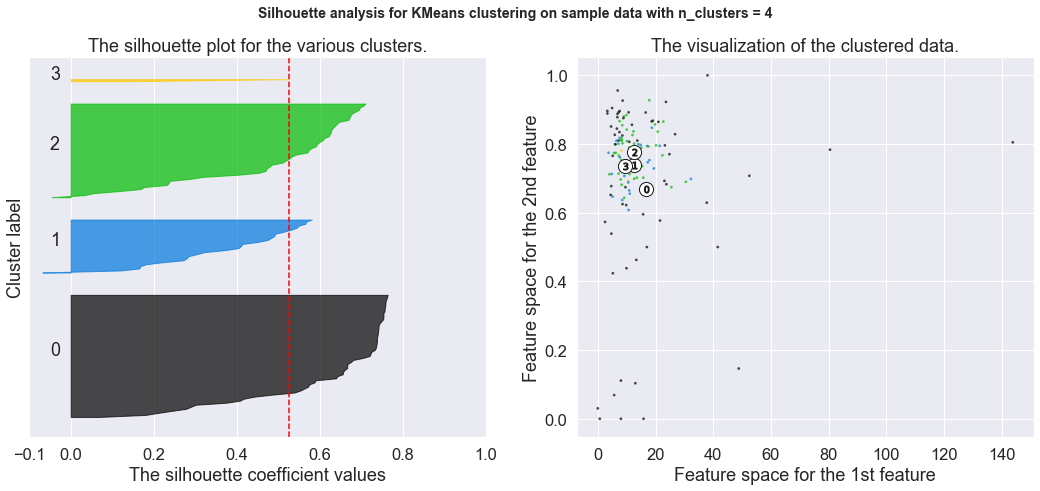

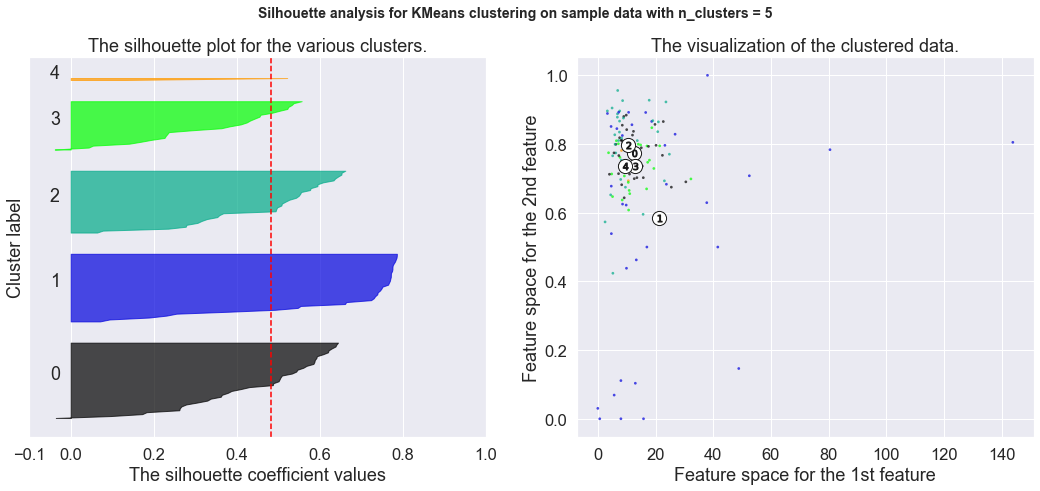

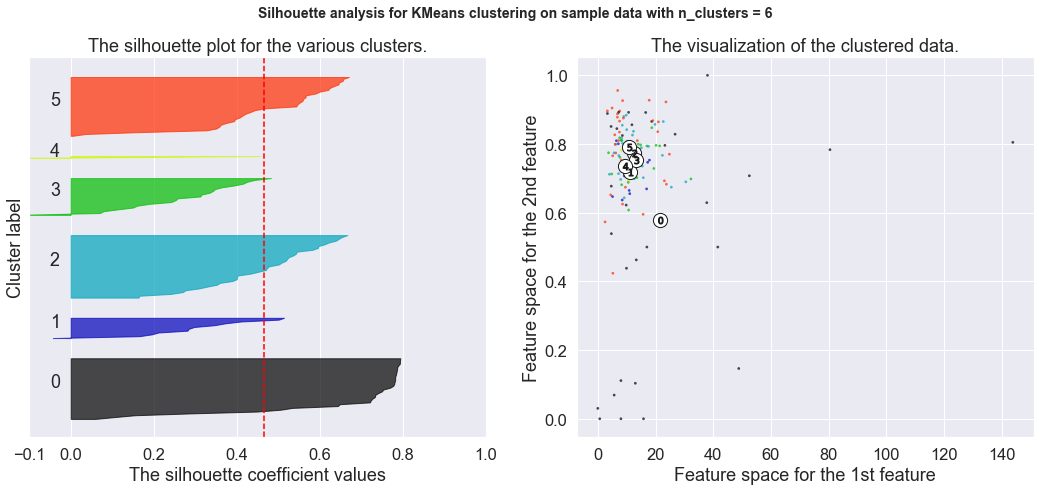

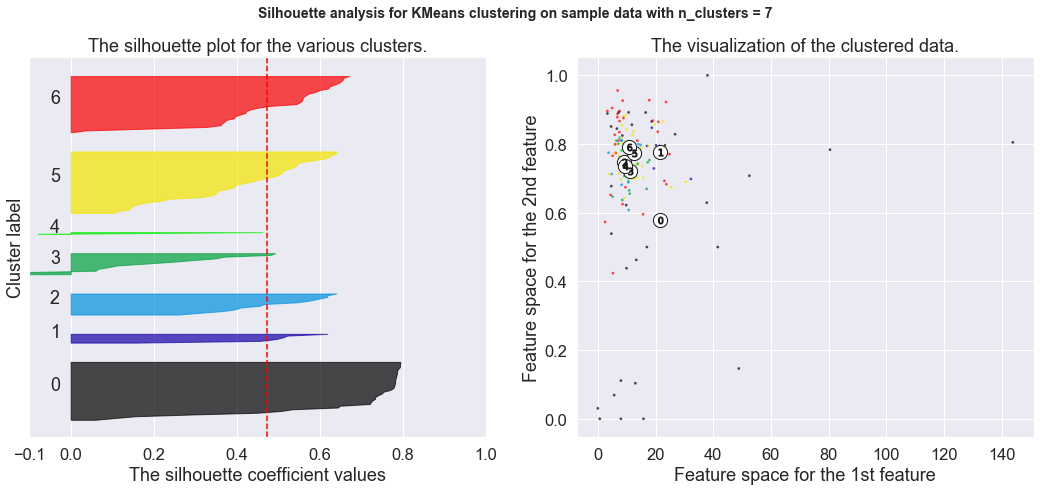

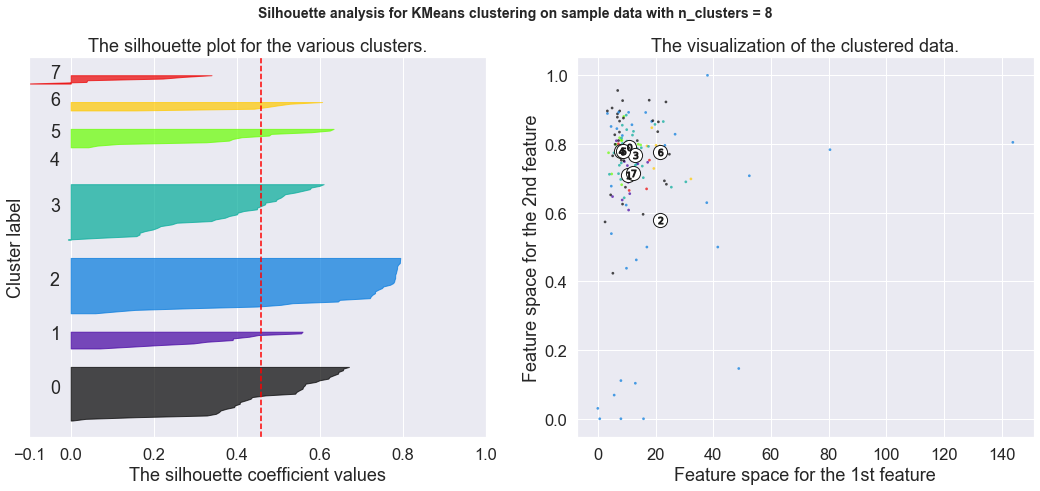

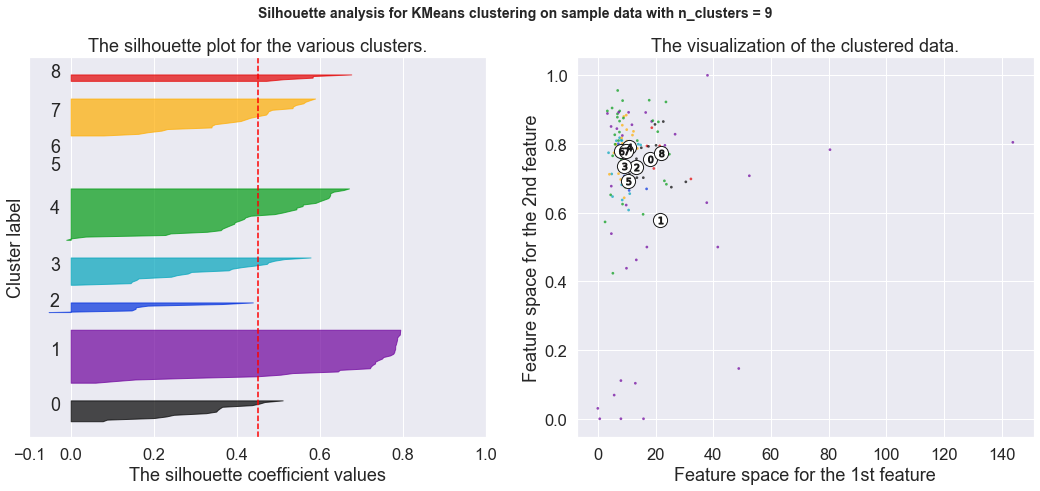

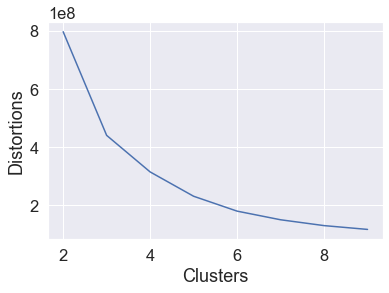

In [1000]:
draw_silhouette_plots(student_df_extra.values)

Ootuspäraselt ei tekkinud ilusaid eristatavaid klastreid kui anda palju andmeid sisse. Järgmiseks proovin vaadata, mis juhtub, kui osad väljad ära võtta.

In [1001]:
student_df_extra_only, extra_columns = load_dataset('students_extra_only.csv')
used_columns_extra = getColumns("students_extra_only.csv")

student_df_extra_only_pandas = pd.read_csv("students_extra_only.csv", 
                      header=2, 
                      names=used_columns_extra)

Siin on näha uued kasutusel olevad kolumnid ning nende jaotusdiagrammid, et saaks uurida, millised kolumnid kudidas omavahel seotud on.

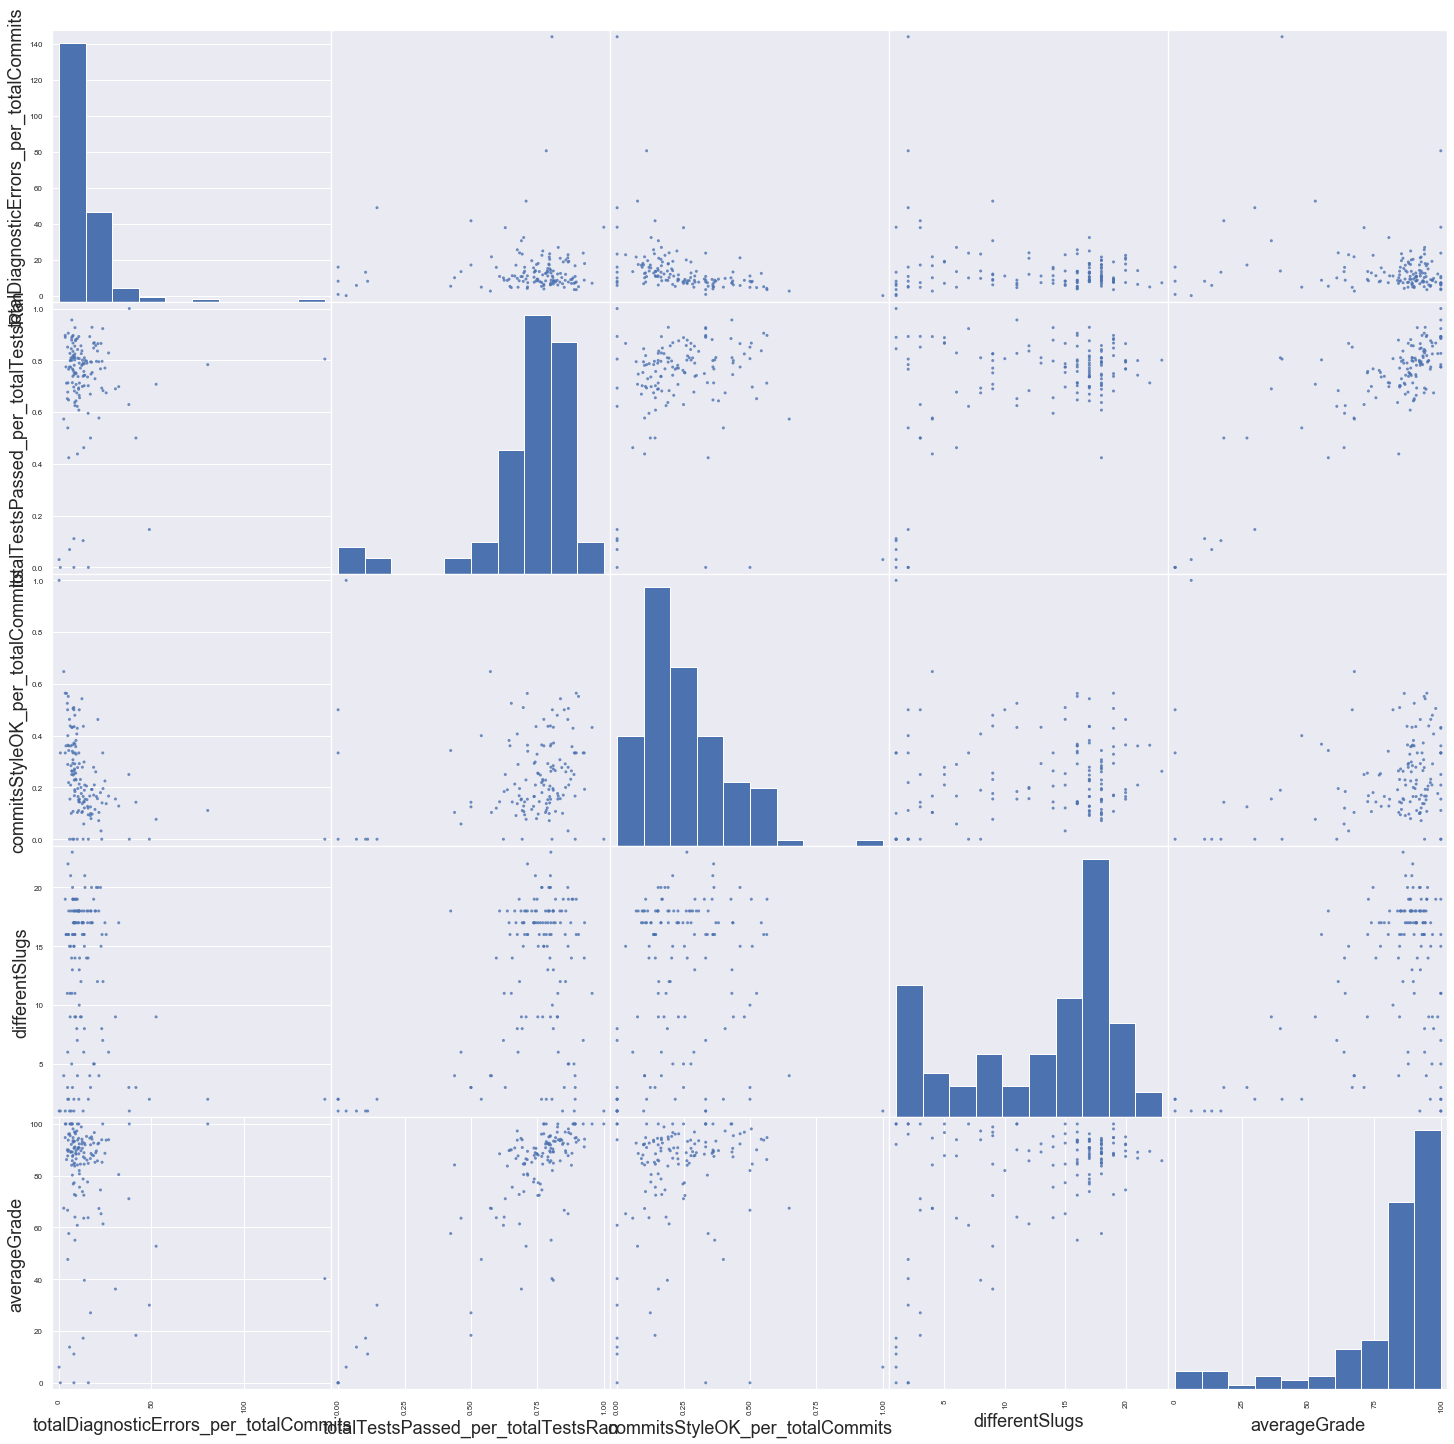

In [1002]:
_ = scatter_matrix(student_df_extra_only_pandas ,figsize = (25, 25), alpha=0.8)

For n_clusters = 2 The average silhouette_score is : 0.7187492821512274
For n_clusters = 3 The average silhouette_score is : 0.7206387374319115
For n_clusters = 4 The average silhouette_score is : 0.4798973011186578
For n_clusters = 5 The average silhouette_score is : 0.48358624152741564
For n_clusters = 6 The average silhouette_score is : 0.48218496259634364
For n_clusters = 7 The average silhouette_score is : 0.3452718701274139
For n_clusters = 8 The average silhouette_score is : 0.35382178932402353
For n_clusters = 9 The average silhouette_score is : 0.33614828747599174


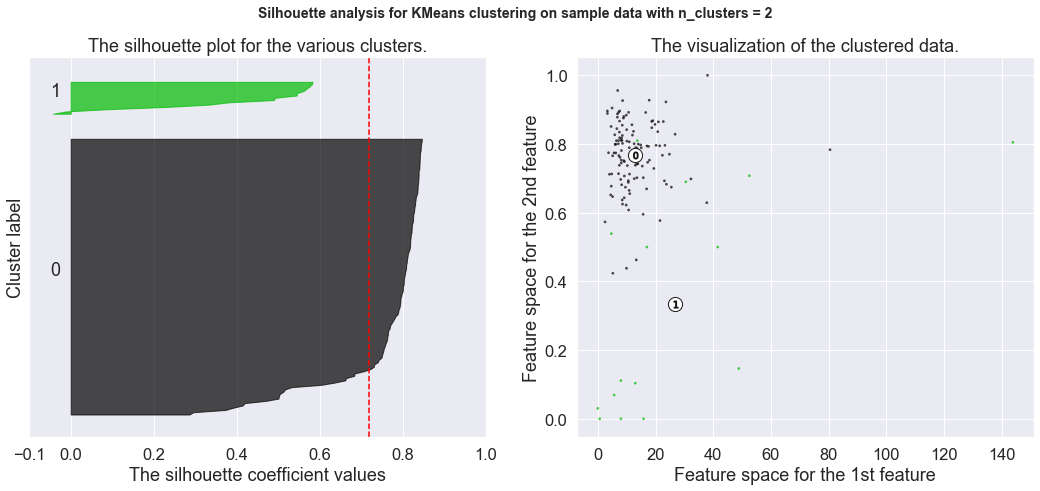

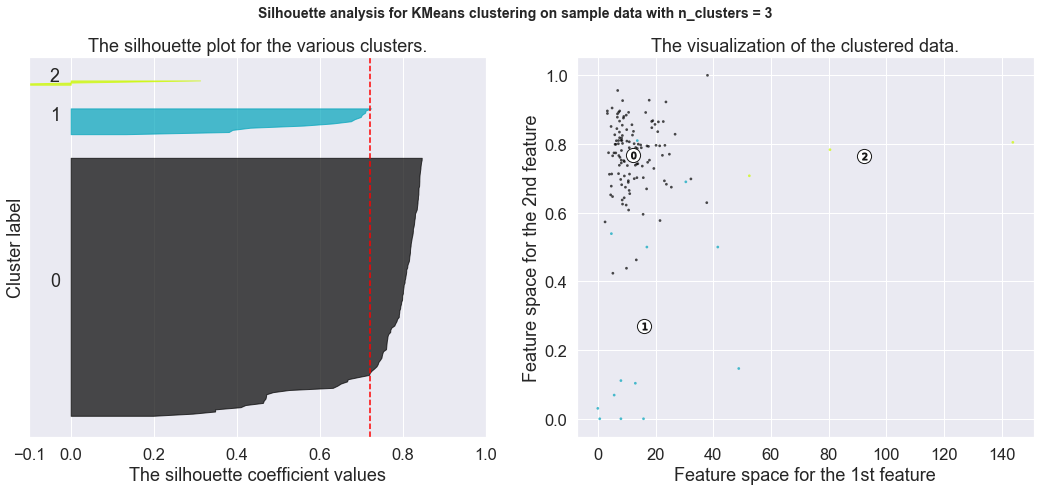

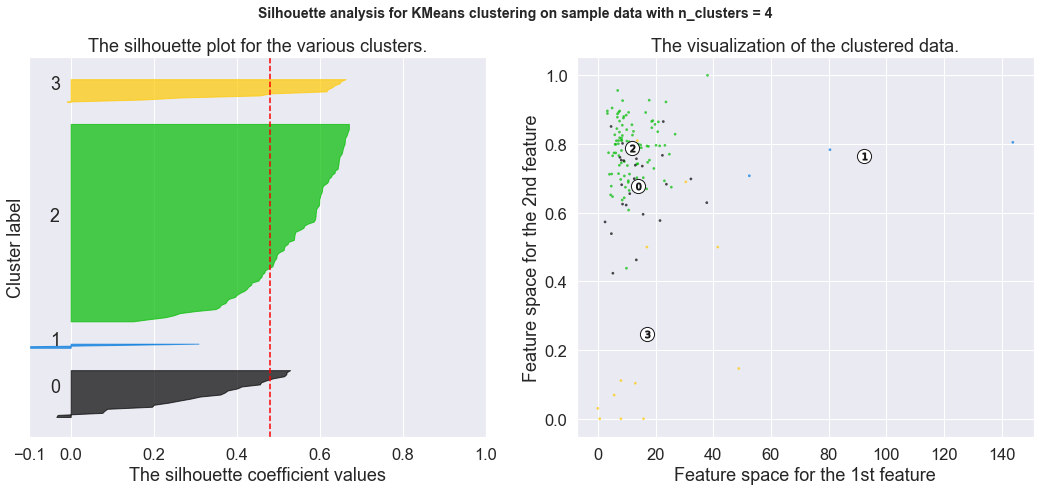

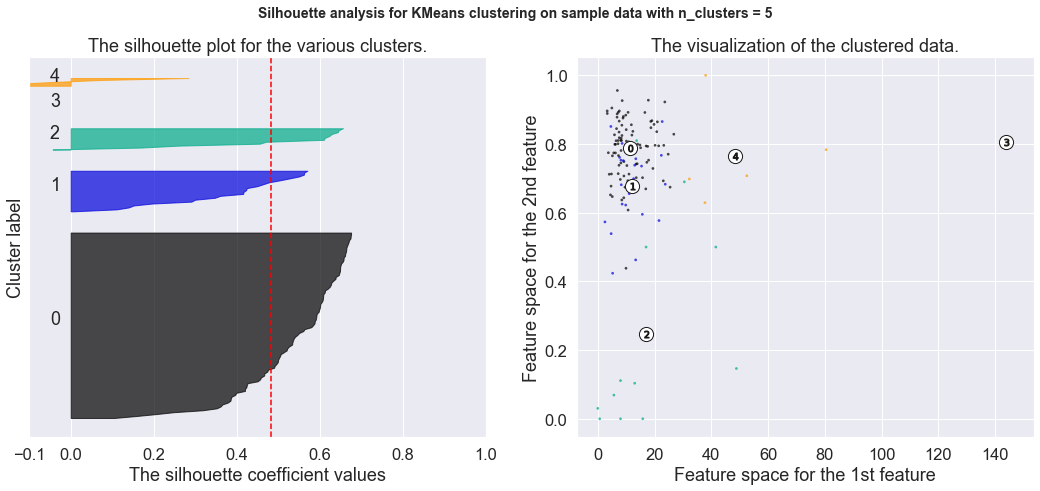

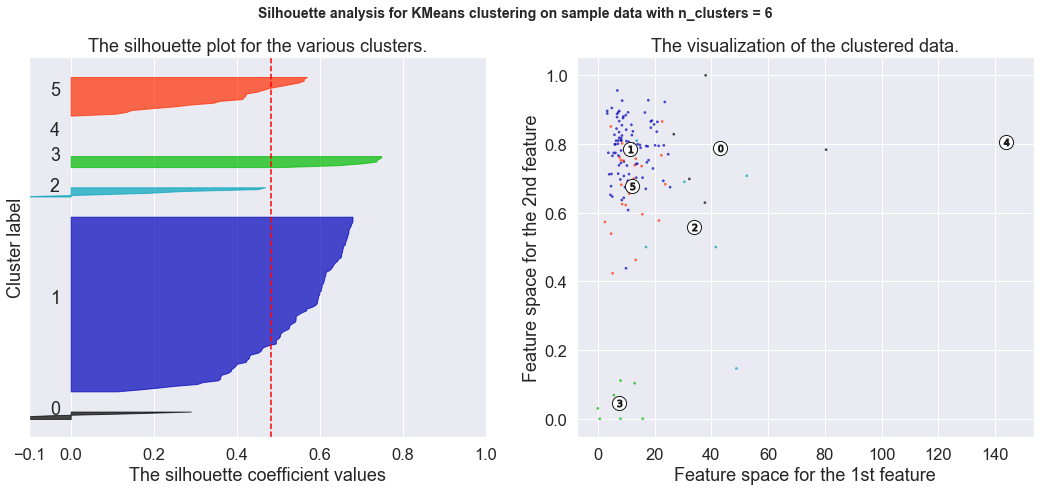

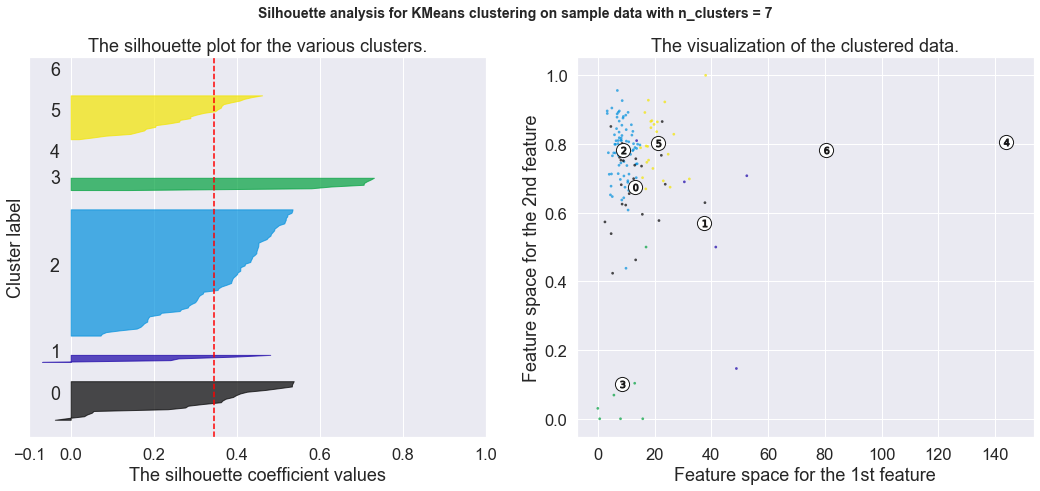

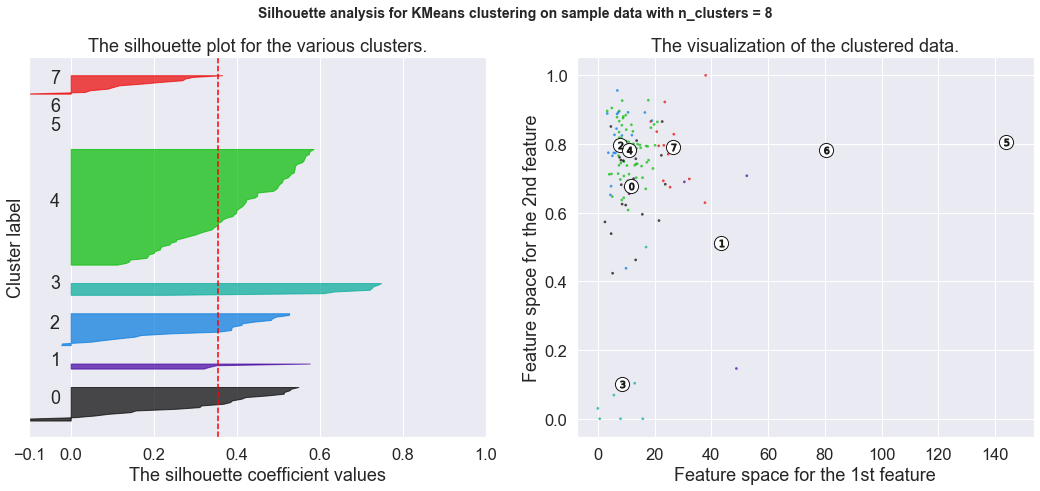

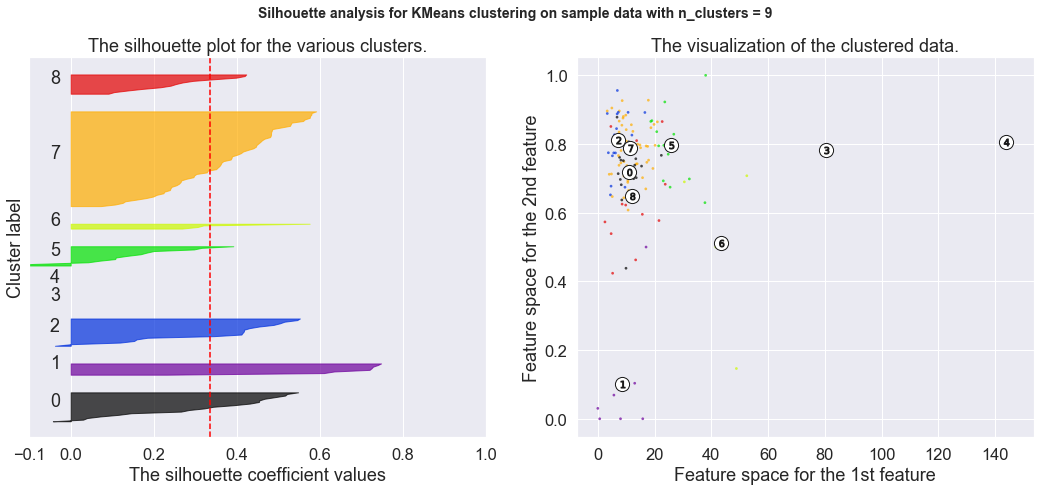

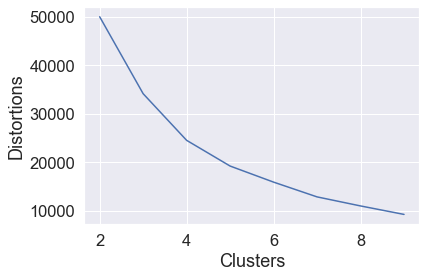

In [1003]:
draw_silhouette_plots(student_df_extra_only_pandas.values)

Vaadates nüüd klastrite kujunemist saab öelda, et erinevuseid leidub ning tudengeid saab klasterdada.

Klastrite arvu 3 puhul oli siluetti keskmine skoor: 0.7206387374319115, mis on päris hea.

Sellest saab järeldada, et tudengeid saab jagada kolme klastrisse.

Pideva väärtuse ennustamiseks loeb andmestiku uuesti sisse aga õigel kujul, et saaks neid lihtsamini kasutada

In [1004]:
import matplotlib.pyplot as plt
import csv
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, learning_curve, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import Perceptron, LinearRegression, LogisticRegression
from sklearn.datasets.base import Bunch
from sklearn import utils
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

student_df2, columns2 = load_dataset('students.csv')
print("Average grades after conversion:\n", student_df2.target)
X_train, X_test, y_train, y_test = train_test_split(student_df2.data, student_df2.target, test_size=0.2, random_state=42)

Average grades after conversion:
 [ 80 100  90  90  90  80 100 100  20  90  70  90  90  80 100  90  90  90
  80  80  90  90  80  90  90  90  90  90  90  90 100  90  90  90  90  90
  90  90  90 100  90  90  90  80  70  80  90 100  90  80  80  90  70  90
  70 100  80 100  90  90  30  90  70  90  90  90  90  60  90  90  90  90
  70  90 100  90  90  90  90  80  30  60  90  80  70  80  90 100  90  60
  40  90  80  70  90  60  90  10  60  90 100  90  90  80 100 100  40  50
  80 100  90 100  90  60  90 100  50   0  90  20 100 100 100  90  10  90
  70 100  60 100   0  70 100 100  80   0  40  10]


Järgmiseks vaatab, kas andmeid on piisavalt, hinnates selle õppimiskõverat

In [1005]:
def validation_curve():
    train_sizes, train_scores, test_scores =\
                    learning_curve(estimator=pipe_lr,
                                   X=X_train,
                                   y=y_train,
                                   cv=2,
                                   n_jobs=10)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    %matplotlib inline

    plt.plot(train_sizes, train_mean,
             color='blue', marker='o',
             markersize=5, label='training accuracy')

    plt.fill_between(train_sizes,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label='validation accuracy')

    plt.fill_between(train_sizes,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='green')

    plt.grid()
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0, 1.0])
    plt.tight_layout()
    plt.show()

In [1006]:
def printScore():  # Cross validation
    scores = cross_val_score(estimator=pipe_lr,
                             X=X_train,
                             y=y_train,
                             cv=2)
    print('CV keskmine täpsus: %.3f' % np.mean(scores), "+/- %.3f" % np.std(scores))

In [1007]:
def print_confusion_matrix():
    print("\nEksimaatriks, kus telgedel on ennustatavad (y-telg) ja ennustatud(x-telg) väärtused:")
    pipe_lr.fit(X_train, y_train)
    y_pred = [int(round(x / 10) * 10) for x in pipe_lr.predict(X_test)]
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    cols = [str(i) for i in range(100 - (len(confmat) * 10) + 10, 110, 10)]
    df_cm = pd.DataFrame(confmat, index=cols, columns=cols)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True)

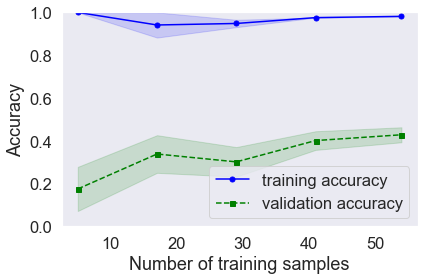

CV keskmine täpsus: 0.446 +/- 0.017

Eksimaatriks, kus telgedel on ennustatavad (y-telg) ja ennustatud(x-telg) väärtused:


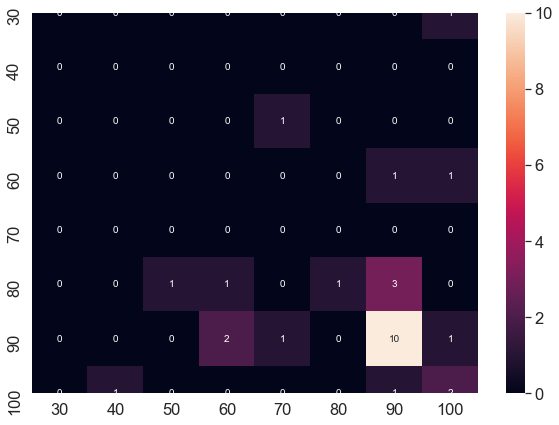

In [1008]:
pipe_lr = Pipeline([('sc1', SelectKBest(k=2)),
                    ('pca', DecisionTreeClassifier())])

validation_curve()
printScore()
print_confusion_matrix()

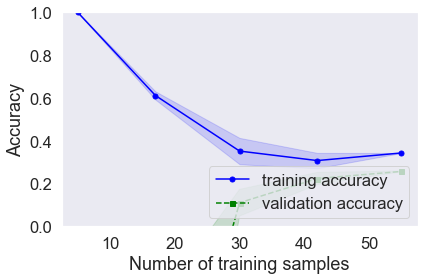

CV keskmine täpsus: 0.257 +/- 0.002

Eksimaatriks, kus telgedel on ennustatavad (y-telg) ja ennustatud(x-telg) väärtused:


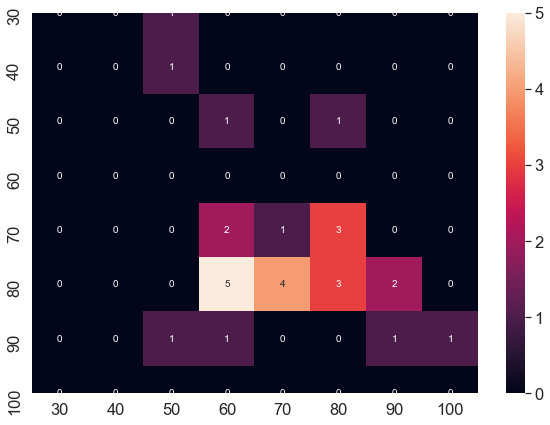

In [1009]:
pipe_lr = Pipeline([('norm', StandardScaler()), 
                ('lr', LinearRegression())])

validation_curve()
printScore()
print_confusion_matrix()

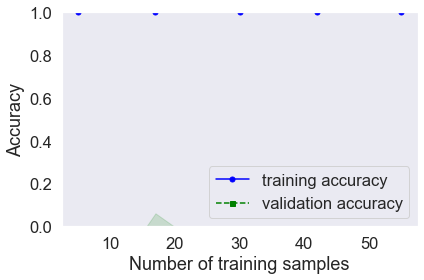

CV keskmine täpsus: -0.415 +/- 0.314

Eksimaatriks, kus telgedel on ennustatavad (y-telg) ja ennustatud(x-telg) väärtused:


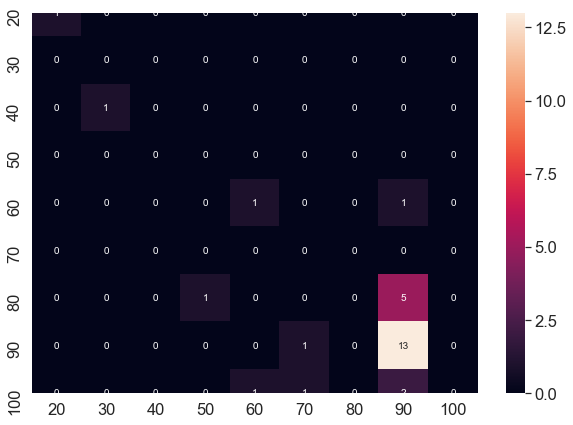

In [1010]:
pipe_lr = Pipeline([('tree', DecisionTreeRegressor())])

validation_curve()
printScore()
print_confusion_matrix()

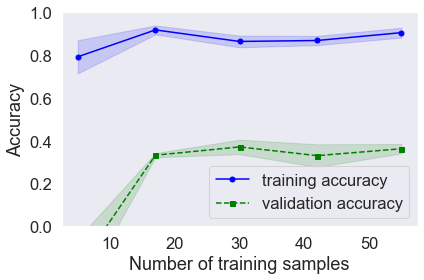

CV keskmine täpsus: 0.371 +/- 0.007

Eksimaatriks, kus telgedel on ennustatavad (y-telg) ja ennustatud(x-telg) väärtused:


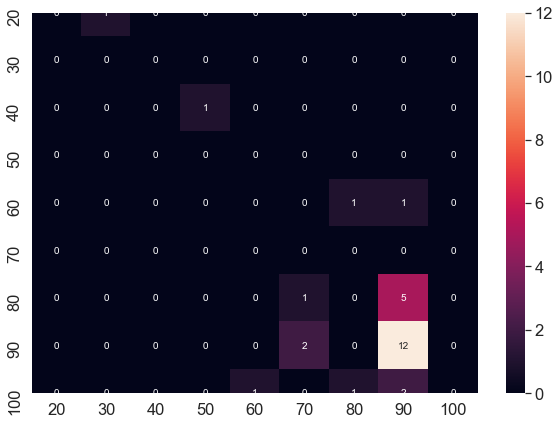

In [1011]:
pipe_lr = Pipeline([('rfr', RandomForestRegressor(n_estimators=500, criterion='mse'))])

validation_curve()
printScore()
print_confusion_matrix()

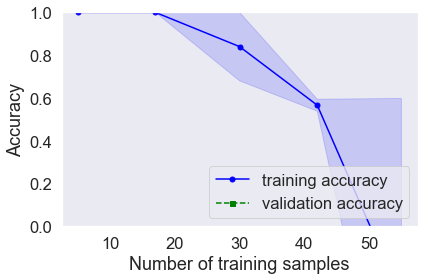

CV keskmine täpsus: -5.936 +/- 1.314

Eksimaatriks, kus telgedel on ennustatavad (y-telg) ja ennustatud(x-telg) väärtused:


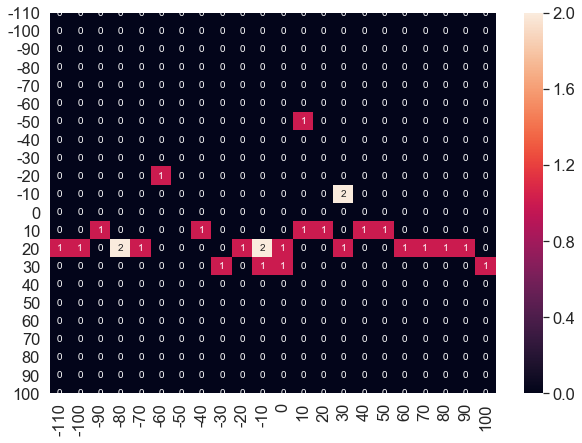

In [1012]:
pipe_lr = Pipeline(steps = [('pf', PolynomialFeatures()), ('lr', LinearRegression())])

validation_curve()
printScore()
print_confusion_matrix()

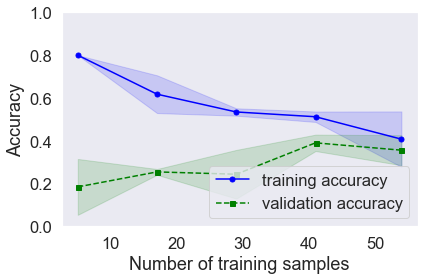

CV keskmine täpsus: 0.347 +/- 0.061

Eksimaatriks, kus telgedel on ennustatavad (y-telg) ja ennustatud(x-telg) väärtused:


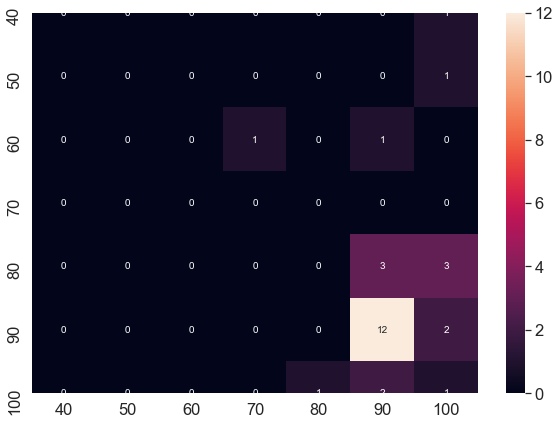

In [1013]:
pipe_lr = Pipeline([('sc', StandardScaler()),
                    ('pca', PCA()),
                    ('per', Perceptron())])

validation_curve()
printScore()
print_confusion_matrix()

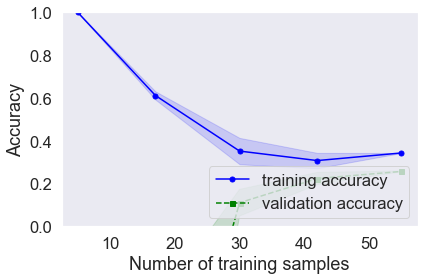

CV keskmine täpsus: 0.257 +/- 0.002

Eksimaatriks, kus telgedel on ennustatavad (y-telg) ja ennustatud(x-telg) väärtused:


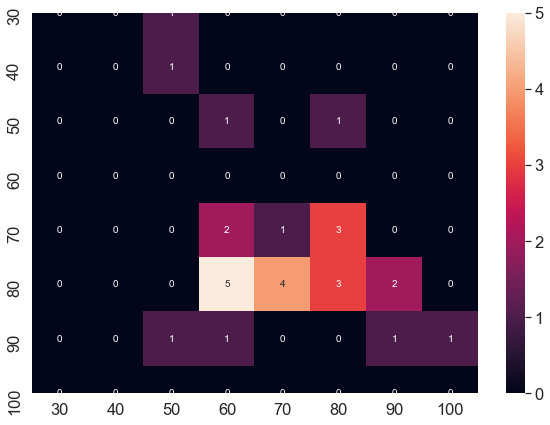

In [1014]:
pipe_lr = Pipeline(steps = [('lr', LinearRegression())])

validation_curve()
printScore()
print_confusion_matrix()

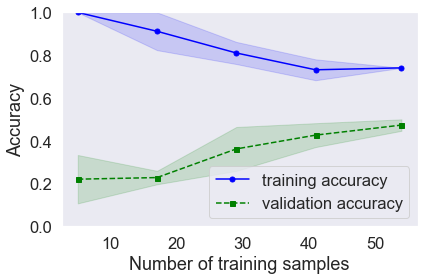

CV keskmine täpsus: 0.482 +/- 0.036

Eksimaatriks, kus telgedel on ennustatavad (y-telg) ja ennustatud(x-telg) väärtused:


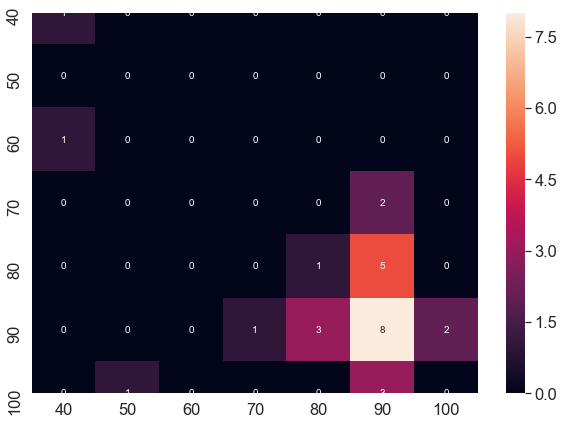

In [1015]:
pipe_lr = Pipeline(steps = [('lr', LogisticRegression())])

validation_curve()
printScore()
print_confusion_matrix()

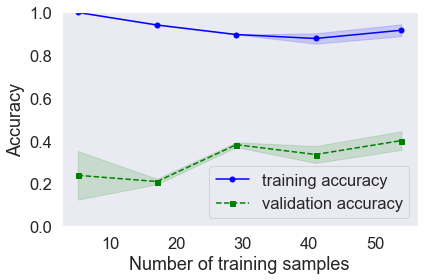

CV keskmine täpsus: 0.392 +/- 0.034

Eksimaatriks, kus telgedel on ennustatavad (y-telg) ja ennustatud(x-telg) väärtused:


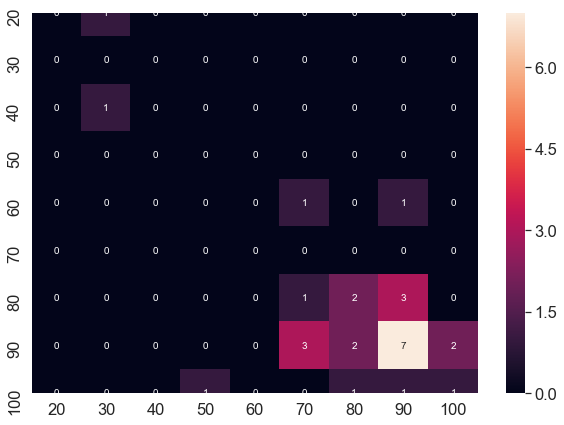

In [1016]:
pipe_lr = Pipeline(steps = [('pf', PolynomialFeatures()), ('lr', LogisticRegression())])

validation_curve()
printScore()
print_confusion_matrix()

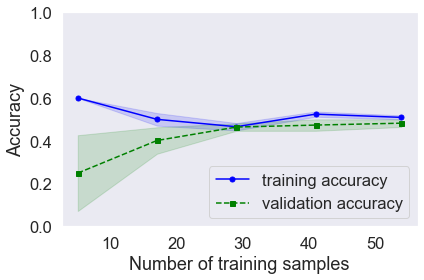

CV keskmine täpsus: 0.482 +/- 0.018

Eksimaatriks, kus telgedel on ennustatavad (y-telg) ja ennustatud(x-telg) väärtused:


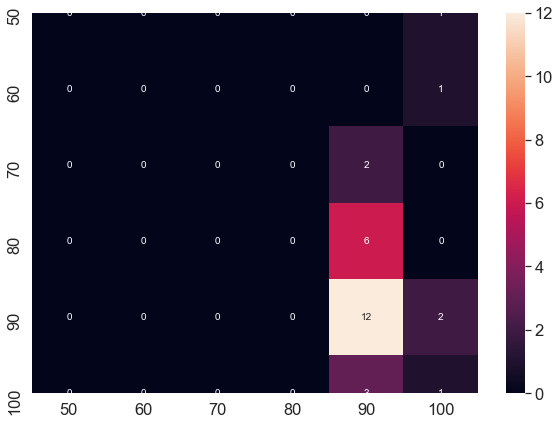

In [1017]:
pipe_lr = Pipeline(steps = [('mms', MinMaxScaler()), ('lr', LogisticRegression())])

validation_curve()
printScore()
print_confusion_matrix()

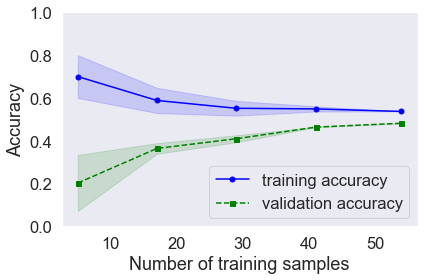

CV keskmine täpsus: 0.482 +/- 0.000

Eksimaatriks, kus telgedel on ennustatavad (y-telg) ja ennustatud(x-telg) väärtused:


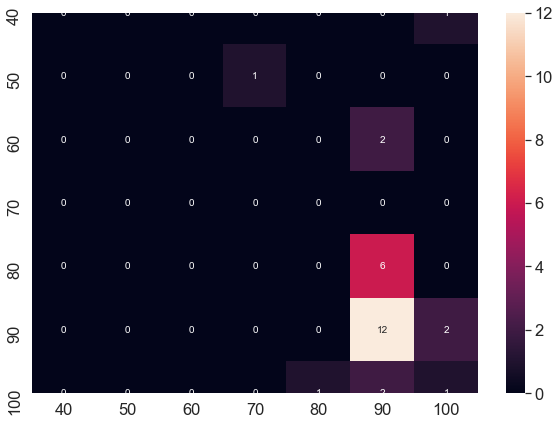

In [1018]:
pipe_lr = Pipeline(steps = [('ss', StandardScaler()), ('lr', LogisticRegression())])

validation_curve()
printScore()
print_confusion_matrix()

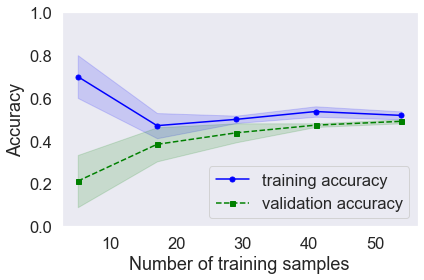

CV keskmine täpsus: 0.491 +/- 0.009

Eksimaatriks, kus telgedel on ennustatavad (y-telg) ja ennustatud(x-telg) väärtused:


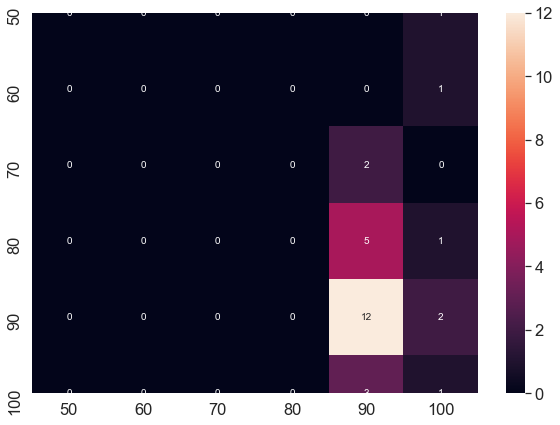

In [1019]:
pipe_lr = Pipeline([('sc1', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression())])

validation_curve()
printScore()
print_confusion_matrix()


Tulemused:
    * PolynomialFeatures() ning LinearRegression() andis tulemuseks -5.936 +/- 1.314
    * DecisionTreeRegressor() andis tulemuseks -0.017 +/- 0.056
    * StandardScaler() ning LinearRegression() andis tulemuseks 0.257 +/- 0.002
    * LinearRegression() andis tulemuseks 0.257 +/- 0.002
    * RandomForestRegressor() andis tulemuseks 0.316 +/- 0.068
    * StandardScaler(), PCA() ning Perceptron() andis tulemuseks 0.347 +/- 0.061
    * PolynomialFeatures() ning LogisticRegression() andis tulemuseks 0.392 +/- 0.034
    * SelectKBest(k=2) ning  DecisionTreeClassifier() andis tulemuseks 0.428 +/- 0.017
    * LogisticRegression() andis tulemuseks 0.482 +/- 0.036
    * MinMaxScaler() ning  LogisticRegression() andis tulemuseks 0.482 +/- 0.018
    * StandardScaler() ning LogisticRegression() andis tulemuseks 0.482 +/- 0.000
    * StandardScaler(), PCA() ning LogisticRegression() andis tulemuseks 0.482 +/- 0.000

Kõik mudelid, mis kasutasid logistilist regressiooni andsid häid tulemusi.

StandardScaler(), PCA() ning LogisticRegression() pipeline andis kõige paremaid tulemusi. Nüüd tuunin hüperparameetritega seda.

In [1020]:
pipe_lr = Pipeline([('sc1', StandardScaler()),
                    ('pca', PCA()),
                    ('lgr', LogisticRegression())])

param_grid = [{'pca__n_components': [1, 2, 3, 4, 5], 
               'lgr__max_iter': [10, 100, 500, 1000],
               'lgr__solver': ["newton-cg", "lbfgs", "sag", "saga"],
               'lgr__penalty': ["l2", "none"]
              }]

gs = GridSearchCV(estimator=pipe_lr, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)

print('Täpsus: ', gs.best_score_)
print(gs.best_params_) # {'lgr__max_iter': 10, 'lgr__penalty': 'l2', 'lgr__solver': 'newton-cg', 'pca__n_components': 2}

Täpsus:  0.509090909090909
{'lgr__max_iter': 100, 'lgr__penalty': 'none', 'lgr__solver': 'lbfgs', 'pca__n_components': 5}


Parim mudel keskmise hinde arvutamiseks järgmine:
    * StandardScaler(), PCA(n_components=2) ning LogisticRegression(max_iter=10, penalty='l2', solver='newton-cg')

In [ ]:
pipe_lr = Pipeline([('sc1', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('lgr', LogisticRegression(max_iter=10, penalty='l2', solver='newton-cg'))])

validation_curve()
printScore()
print_confusion_matrix()

StandardScaler(), PCA(n_components=2) ning LogisticRegression(max_iter=10, penalty='l2', solver='newton-cg') annab tulemuseks 0.500 +/- 0.018. See pole just parim tulemus. Tulemuse parendamiseks peaks ootama aasta aega kuni testimiselt tuleb rohkem andmeid.

Kokkuvõte:

Tudengeid andis jagada kolme klastrisse nii, et siluetti skoor oli  0.72, mis oli parim skoor võimalike klastrite arvu poolest. Klastrid moodustusid tudengite õppeedukuse põhjal

Pideva muutuja ennustamisel valisin pidevaks muutujaks averageGrade'i. Parim mudel selle ennustamiseks oli pipeline, mis koosnes järgnevatest komponentidest:
 - StandardScaler()
 - PCA(n_components=2) 
 - LogisticRegression(max_iter=10, penalty='l2', solver='newton-cg')

Ning mis andis tulemuseks 0.5, mis ole just parim tulemus. Aga Kui järgmine aasta seda faili uuesti jooksutada, siis peaks see tulemus tõusma, kuna siis on juba rohkem andmeid tudengite testimiste kohta.

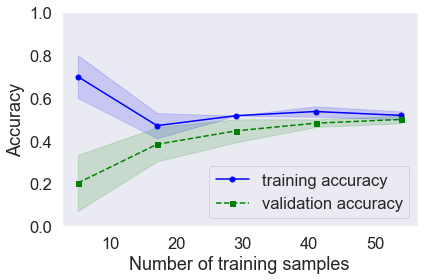

CV keskmine täpsus: 0.500 +/- 0.018

Eksimaatriks, kus telgedel on ennustatavad (y-telg) ja ennustatud(x-telg) väärtused:


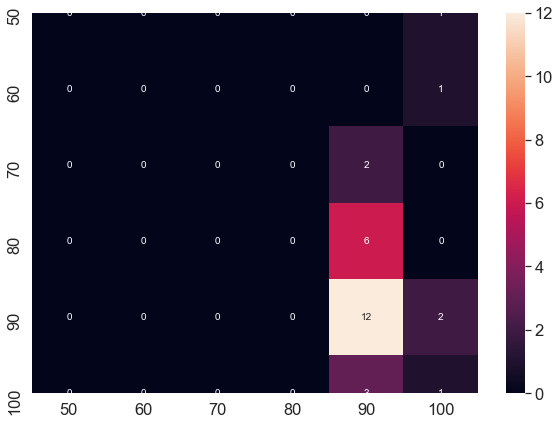

In [1021]:
Kokkuvõte:

Tudengeid andis jagada kolme klastrisse nii, et siluetti skoor oli  0.72, mis oli parim skoor võimalike klastrite arvu poolest. Klastrid moodustusid tudengite õppeedukuse põhjal

Pideva muutuja ennustamisel valisin pidevaks muutujaks averageGrade'i. Parim mudel selle ennustamiseks oli pipeline, mis koosnes järgnevatest komponentidest:
 - StandardScaler()
 - PCA(n_components=2) 
 - LogisticRegression(max_iter=10, penalty='l2', solver='newton-cg')

Ning mis andis tulemuseks 0.5, mis ole just parim tulemus. Aga Kui järgmine aasta seda faili uuesti jooksutada, siis peaks see tulemus tõusma, kuna siis on juba rohkem andmeid tudengite testimiste kohta.

StandardScaler(), PCA(n_components=2) ning LogisticRegression(max_iter=10, penalty='l2', solver='newton-cg') annab tulemuseks 0.500 +/- 0.018. See pole just parim tulemus. Tulemuse parendamiseks peaks ootama aasta aega kuni testimiselt tuleb rohkem andmeid.

Kokkuvõte:

Tudengeid andis jagada kolme klastrisse nii, et siluetti skoor oli  0.72, mis oli parim skoor võimalike klastrite arvu poolest. Klastrid moodustusid tudengite õppeedukuse põhjal

Pideva muutuja ennustamisel valisin pidevaks muutujaks averageGrade'i. Parim mudel selle ennustamiseks oli pipeline, mis koosnes järgnevatest komponentidest:
 - StandardScaler()
 - PCA(n_components=2) 
 - LogisticRegression(max_iter=10, penalty='l2', solver='newton-cg')

Ning mis andis tulemuseks 0.5, mis ole just parim tulemus. Aga Kui järgmine aasta seda faili uuesti jooksutada, siis peaks see tulemus tõusma, kuna siis on juba rohkem andmeid tudengite testimiste kohta.